In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# from tensorflow.keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.inception_v3 import InceptionV3

import numpy as np
import pandas as pd
import pickle
import random
from sklearn.model_selection import train_test_split
import skimage.io
import skimage
%load_ext tensorboard
# from google.colab.patches import cv2_imshow

In [2]:
# %load_ext tensorboard


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
epochs = 15
batch_size = 4
ImgDir = "Cube/"

features = os.listdir(f"{ImgDir}features/")
labels = os.listdir(f"{ImgDir}labels/")

print(len(features), len(labels))

4000 4000


In [5]:
features = os.listdir(f"{ImgDir}features/")
labels = os.listdir(f"{ImgDir}labels/")

print(len(features), len(labels))

4000 4000


In [6]:
X = features
y = labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.15, random_state=1)

print(len(X_train), len(X_val), len(X_test))
# print(X_train[0].sum())

2800 1020 180


In [7]:
def keras_generator_train_val_test(batch_size, choice="train"):

    if choice == "train":
        X = X_train
        y = y_train
    elif choice == "val":
        X = X_val
        y = y_val
    elif choice == "test":
        X = X_test
        y = y_test
    else:
        print("Invalid Option")
        return False
        
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            x_rand = random.choice(X)
            y_rand = x_rand[:-7]+"layer.png"
            
            x_path = f"{ImgDir}features/{x_rand}"
            y_path = f"{ImgDir}labels/{y_rand}"

#             x = cv2.imread(x_path)
#             y = cv2.imread(y_path)
            x = skimage.io.imread(x_path)
            y = skimage.io.imread(y_path)

            x = x / 255.
            y = y / 255.
            
            x_batch.append(x)
            y_batch.append(y)

        
        x_batch = np.array(x_batch)
        # y_batch = np.array(y_batch)

        y_batch = {'seg': np.array(y_batch),
                #    'cls': np.array(classification_list)
                }

        yield x_batch, y_batch

    for x, y in keras_generator_train_val_test(2, choice="train"):
        break

    print(x.shape, y['seg'].shape)

In [8]:
def get_model():
    in1 = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3 ))

    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    losses = {'seg': 'binary_crossentropy'}

    metrics = {'seg': ['acc']
                }
    model.compile(optimizer="adam", loss=losses, metrics=metrics)

    return model

In [9]:
import datetime

class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, epoch, logs={}):

        res_dir = "intermediate_results_purple_background"

        try:
            os.makedirs(res_dir)
        except:
            print(f"{res_dir} directory already exist")

        print('Training: epoch {} begins at {}'.format(epoch, datetime.datetime.now().time()))

    def on_epoch_end(self, epoch, logs=None):
        res_dir = "intermediate_results_purple_background/"
        print('Training: epoch {} ends at {}'.format(epoch, datetime.datetime.now().time()))
        
        for x_test, y_test in keras_generator_train_val_test(batch_size, choice="test"):
            break
        p = np.reshape(x_test[0], (1, 512, 512, 3))
        prediction = self.model.predict(p)

        x_img = f"{res_dir}{epoch}_X_input.jpg"
        y_img = f"{res_dir}{epoch}_Y_truth.jpg"
        predicted_img = f"{res_dir}{epoch}_Y_predicted.jpg"

        skimage.io.imsave(x_img, np.uint8(x_test[0] * 255.))
        skimage.io.imsave(y_img, np.uint8(y_test['seg'][0] * 255.))
        skimage.io.imsave(predicted_img, np.uint8(prediction[0] * 255.))

In [20]:
# model = get_model()
model = tf.keras.models.load_model('saved_model/4_norm_model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [21]:

model_name = "models/"+"Unet_5purple_background.h5"



In [22]:
modelcheckpoint = ModelCheckpoint(model_name,
                                  monitor='val_loss',
                                  mode='auto',
                                  verbose=1,
                                  save_best_only=True)

lr_callback = ReduceLROnPlateau(min_lr=0.000001)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


callback_list = [modelcheckpoint, lr_callback, MyCustomCallback(), tensorboard_callback]

# with tf.device("/device:GPU:0"):
#     history = model.fit(
#         keras_generator_train_val_test(batch_size, choice="train"),
#         validation_data = keras_generator_train_val_test(batch_size, choice="val"),
#         validation_steps = 300,
#         steps_per_epoch=400,
#         epochs=epochs,
#         verbose=1, 
#         shuffle=True,
#         callbacks = callback_list,
#     )

In [23]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 17640), started 5:17:44 ago. (Use '!kill 17640' to kill it.)

In [24]:
# %tensorboard --logdir logs

In [25]:
from skimage.transform import resize
def show_pred(files):
    kol = len(files)
    plt.figure(figsize=(22,kol*6))
    
    
    for i in range(kol):
        image = skimage.io.imread(files[i])
        i += 1
        s = np.array([resize(image,(IMG_HEIGHT, IMG_WIDTH))])
        if s.max() > 1:
            s = s / 255.0
            
        im = skimage.img_as_ubyte(s[0])
        mask = skimage.img_as_ubyte(model.predict(s)[0])
        re_mask = skimage.img_as_ubyte(model.predict(s/255.0)[0])
        
        plt.subplot(kol,3, (i-1) * 3 + 1)
        plt.imshow(im)

        plt.subplot(kol,3,(i-1) * 3 + 2)
        plt.imshow(mask)

        plt.subplot(kol,3,(i-1) * 3 + 3)
        plt.imshow(mask[:,:, 0])

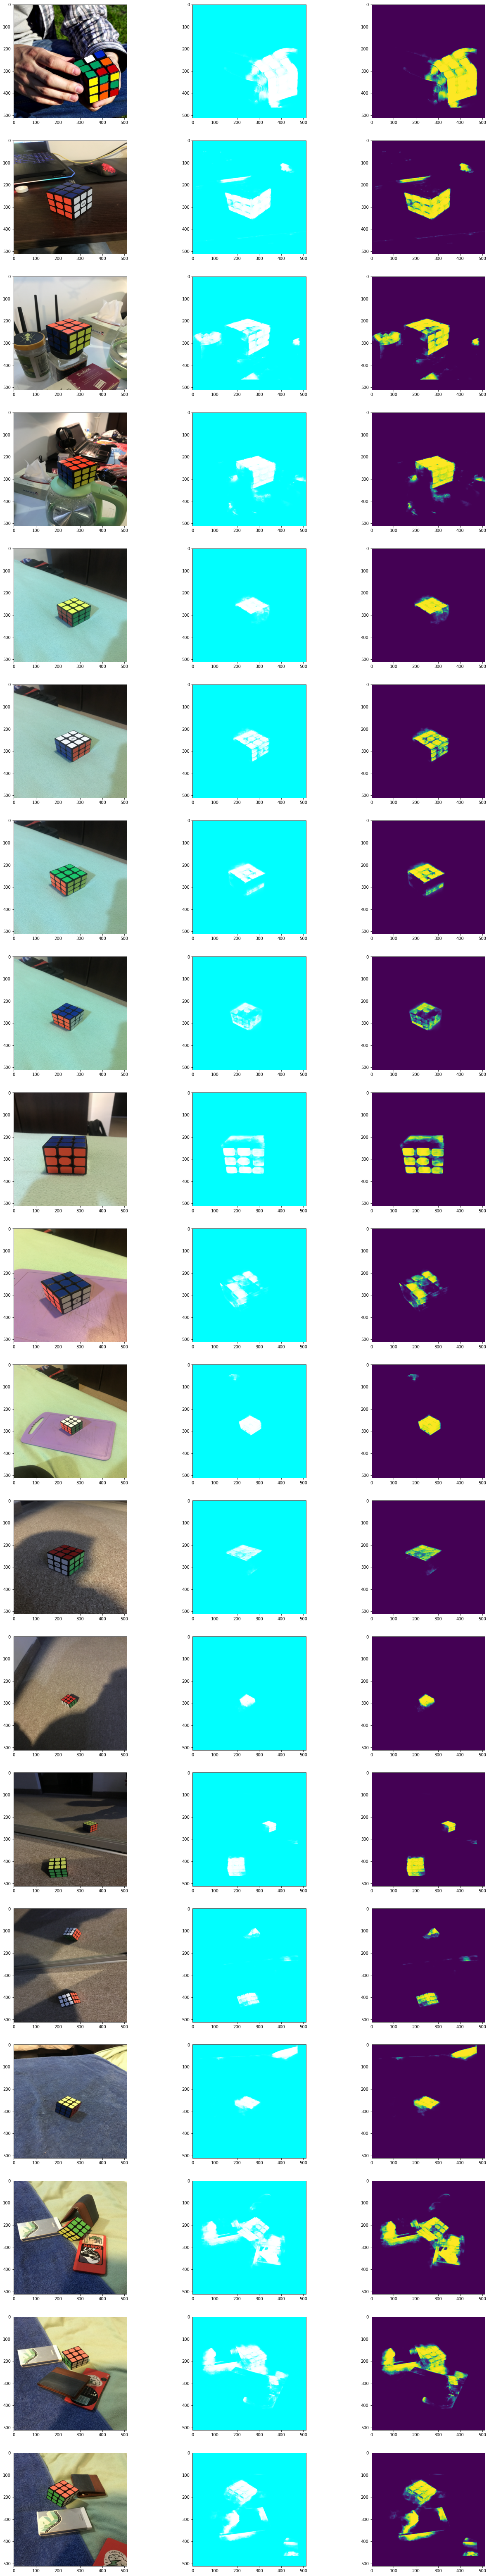

In [26]:
import glob
files = glob.glob('Cube/image_for_test/*')
show_pred(files)

In [17]:
# from skimage.transform import resize
# image_0 = skimage.io.imread('Cube/features/SampleScene_170_img.png')
# image_1 = skimage.io.imread('Cube/1247683.png')
# image_2 = skimage.io.imread('Cube/IMG_8281.JPG')
# image_3 = skimage.io.imread('BBBC018_v1_images-fixed/train/00736-actin.DIB.bmp')
# images = [image_0, image_1,image_2,image_3]
# show_pred(images)

In [18]:
# model.save('saved_model/synt_norm_model')

In [19]:
# pip install jupyter-resource-usage